In [1]:
import numpy as np
import pymesh 
from meshpy.triangle import MeshInfo, build
import meshzoo
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math

In [2]:
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}

            
    def add_node(self, value):
        self.nodes.add(value)

    def add_edge(self, from_node, to_node, distance):
        if to_node not in self.edges[from_node]:
            self.edges[from_node].append(to_node)
            self.edges[to_node].append(from_node)
            self.distances[(from_node, to_node)] = distance
            self.distances[(to_node, from_node)] = distance
    def graph_from_nodes_and_cells(self, nodes, cells):
        for c in cells:
            self.add_node(c[0])
            self.add_node(c[1])
            self.add_node(c[2])
            self.add_edge(c[0],c[1],np.linalg.norm(nodes[c[0]]-nodes[c[1]]))
            self.add_edge(c[0],c[2],np.linalg.norm(nodes[c[0]]-nodes[c[2]]))
            self.add_edge(c[1],c[2],np.linalg.norm(nodes[c[1]]-nodes[c[2]]))


def dijkstra(graph, initial):
    far = set(graph.nodes)
    accepted = {}
    path = {}
    considered = {}
    for init_node in initial:
        accepted[init_node] = 0
        far.remove(init_node)
        for edge in graph.edges[init_node]:
            if edge not in initial and edge not in considered.keys():
                considered[edge] = graph.distances[(init_node, edge)]
                far.remove(edge)
                path[edge] = init_node
    while considered:
        #print(far)
        #print(considered)
        #print(accepted)
        min_node = None
        for node in considered:
            if min_node is None:
                min_node = node
            elif considered[node] < considered[min_node]:
                min_node = node
        if min_node == None:
            break
        accepted[min_node] = considered[min_node]
        del considered[min_node]
        current_weight = accepted[min_node]

   
        for edge in graph.edges[min_node]:
            try:
                weight = current_weight + graph.distances[(min_node, edge)]
            except:
                weight = current_weight + math.inf
            if (edge not in considered.keys() or weight < considered[edge]) and edge not in accepted.keys() :
                considered[edge] = weight
                path[edge] = min_node
                if edge not in considered:
                    far.remove(edge)
        
    distances = []
    for i in range(len(accepted)):
        distances.append(accepted[i])
    
    return distances
        
        

In [3]:
def build_mesh(points, n=1):
    P = n**2*(len(points)-2)#the number of points
    R2_to_R = lambda x: round(x[0]*P + x[1],5)# We need correspondance of a vector in R2 to a single value: (x,y) -> x*P + y
    facets = []#the set of polygon edges
    boundary_nodes_values = [] # the list of values corresponding to the contour nodes
    for i in range(len(points)-1):
        facets.append([i, i+1])#We assume that 'points' is given in the traversal order of the polygon outline 
        for j in range(n):# each edge will have n mesh nodes  
            d = np.array(points[i]) + (j/n)*(np.array(points[i+1]) - np.array(points[i]))
            boundary_nodes_values.append(R2_to_R(d))
    facets.append([len(points)-1, 0])
    for j in range(n):
        d = np.array(points[len(points)-1]) + (j/n)*(np.array(points[0]) - np.array(points[len(points)-1]))
        boundary_nodes_values.append(R2_to_R(d))
    mesh_info = MeshInfo()#we use meshpy to divide our domain into triangles
    mesh_info.set_points(points)
    mesh_info.set_facets(facets)
    mesh = build(mesh_info)#mesh of big triangles has points and elements(these big triangles represented by serial numbers of three nodes)
    all_nodes_values = []
    nodes_all = []
    cells_all = []
    for e in mesh.elements:
        nodes, cells = meshzoo.triangle(n, corners = np.array(mesh.points)[np.array(e)])# we divide each 
        # big triangle into n^2 small triangles using meshzoo
        # 'cells' is the array of small triangles(each is represented by serial numbers of three nodes)
        nodes_dict = {} # dictionary of nodes 
        #{local(in current big triangle) serial number: global(in the whole domain) serial number}
        for i, node in enumerate(nodes):#loop over nodes 
            node_val = R2_to_R(node)
            if node_val not in all_nodes_values:#check if this node is not already in the array of all nodes
                all_nodes_values.append(round(node_val,5))
                nodes_all.append(node)
                nodes_dict[i] = len(nodes_all)-1
            else:
                nodes_dict[i] = all_nodes_values.index(node_val)
        for c in cells:
            cells_all.append([nodes_dict[c[0]],nodes_dict[c[1]],nodes_dict[c[2]]])
            #add each small triangle as three global serial numbers of nodes 
    boundary_nodes = []# the list of global serial numbers corresponding to the contour nodes
    for node_val in boundary_nodes_values:#we convert nodes values into serial numbers 
        boundary_nodes.append(all_nodes_values.index(node_val))
    nodes_all = np.array(nodes_all)
    cells_all = np.array(cells_all)
    g = Graph()
    g.graph_from_nodes_and_cells(nodes_all, cells_all)
    dist = dijkstra(g, boundary_nodes)
    
    triang = mtri.Triangulation(nodes_all[:,0], nodes_all[:,1], cells_all)
    plt.tricontourf(triang, dist)
    plt.triplot(triang, 'ko-')
    plt.title('Triangular grid')
    return nodes_all, cells_all, dist          
        

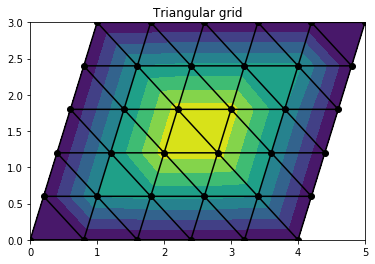

In [4]:
nod, cel, dist = build_mesh([[0,0],[1,3],[5,3],[4,0]], 5)
#print(nod)
#print(cel)
#print(dist)

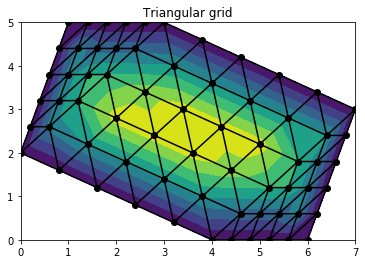

In [5]:
nod, cel, dist = build_mesh([[0,2],[1,5],[3,5],[7,3],[6,0],[4,0]], 5)
#print(nod)
#print(dist)

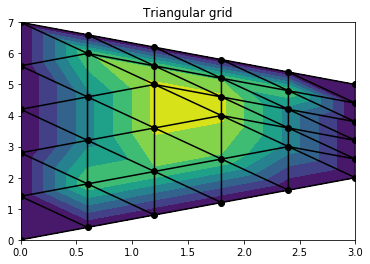

In [6]:
nod, cel, dist = build_mesh([[0,7],[3,5],[3,2], [0,0]], 5)
#print(dist)

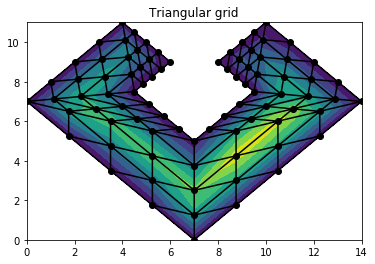

In [7]:
domain_nodes = [[0,7],[4,11],[6,9],[4.5,7.5],[7,5],[9.5,7.5],[8,9],[10,11],[14,7],[7,0]]
nod, cel, dist = build_mesh(domain_nodes, 4)



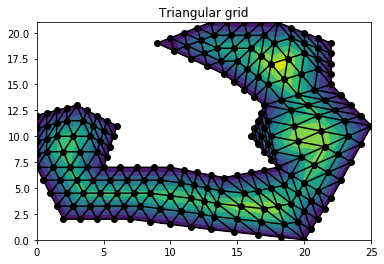

In [8]:
domain_nodes = [[0,12],[3,13],[6,11],[5,7],[10,7],[14,6],[18,7],[16,10],[17,13],[14,16],[9,19],[13,21],[18,21],[22,19],[22,15],[25,11],[22,4],[20,0],[13,1],[7,2],[2,2],[0,7]]
nod, cel, dist = build_mesh(domain_nodes, 4)